## Import Spark

In [1]:
import os
# os.environ["SPARK_HOME"]
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.1
      /_/

Using Python version 3.6.5 (default, Mar 29 2018 13:14:23)
SparkSession available as 'spark'.


In [2]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

## Load data into Spark DataFrame

In [3]:
from pyspark import SparkContext
import pyspark.sql.functions as F
# We use matplotlib for plotting
import matplotlib.pyplot as plt
# This statement allow to display plot without asking to
%matplotlib inline

In [4]:
# df is A Spark DataFrame
df = spark.read.csv('../data/event_ds.csv',header=True).cache()
df

DataFrame[uid: string, event: string, song_id: string, date: string]

In [5]:
# show the first 20 rows of the Spark DataFrame
df.show()

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168535490|    P| 6616004|2017-03-30|
|168551042|    P|  505355|2017-03-30|
|168540348|    P|   77260|2017-03-30|
|168530895|    P|       0|2017-03-30|
|168530479|    P| 1676759|2017-03-30|
|168551607|    P| 5517668|2017-03-30|
|168548101|    P| 6913185|2017-03-30|
|168542680|    P|       0|2017-03-30|
|168550237|    P| 6511070|2017-03-30|
|168519439|    P|       0|2017-03-30|
|168548942|    P| 4112522|2017-03-30|
|168551495|    P|22797719|2017-03-30|
|168551383|    P| 7149583|2017-03-30|
|168550382|    P| 3971726|2017-03-30|
|168548945|    P|20429929|2017-03-30|
|168550086|    P| 7172624|2017-03-30|
|168540348|    P| 6437996|2017-03-30|
|168551522|    P|  150918|2017-03-30|
|168541857|    P|  295529|2017-03-30|
|168546393|    P|  242615|2017-03-30|
+---------+-----+--------+----------+
only showing top 20 rows



---
---
## Data Exploration

### Features Type Casting and Verification

In [6]:
# create new or overwrite original field with withColumn: 
# for "date" column, convert "string" type to "date" type 
# for "id" column, convert "string" type to "int" type
df = df.withColumn('date', F.col('date').cast('date'))
for col in ['uid', 'song_id']:
    df = df.withColumn(col, F.col(col).cast('int'))
df

DataFrame[uid: int, event: string, song_id: int, date: date]

Note that song_id has a **special** negative value and there are missing values in __event__ column

In [7]:
# show the descriptive statistics of the DataFrame
df.describe().show()

+-------+--------------------+-------+-----------------+
|summary|                 uid|  event|          song_id|
+-------+--------------------+-------+-----------------+
|  count|             2194568|2194568|          2049856|
|   mean|1.6645771046223176E8|   null| 5915507.37680842|
| stddev|1.6287908907350207E7|   null|6653398.679705742|
|    min|             2626270|      D|               -1|
|    max|           168941043|      S|         24024145|
+-------+--------------------+-------+-----------------+



### Missing Values
Only Nulls in **song_id** feature.

In [8]:
# Count the number of Nulls in every feature
df.select(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---+-----+-------+----+
|uid|event|song_id|date|
+---+-----+-------+----+
|  0|    0| 144712|   0|
+---+-----+-------+----+



In [9]:
# Check the data with missing values
df.filter(F.col('song_id').isNull()).show(10)

+---------+-----+-------+----------+
|      uid|event|song_id|      date|
+---------+-----+-------+----------+
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
|168564110|    P|   null|2017-03-30|
+---------+-----+-------+----------+
only showing top 10 rows



#### Nulls Pattern Inspection
The song ids of the "search" event are all missing. A tiny proportion of the "play" event song ids is missing. None of song ids is absent in "download" event. 

In [10]:
# group by aggregation
df.groupBy('event').count().show()
df.filter(F.col('song_id').isNull()).groupBy('event').count().show()

+-----+-------+
|event|  count|
+-----+-------+
|    D| 119950|
|    S| 144337|
|    P|1930281|
+-----+-------+

+-----+------+
|event| count|
+-----+------+
|    S|144337|
|    P|   375|
+-----+------+



### Song ids and User ids

In [11]:
# simple count rows
df.count()

2194568

In [12]:
# count number of distinct user ids and song ids
df.select('uid').distinct().count(), df.select('song_id').distinct().count()

(9757, 157320)

### Other Explorations

In [13]:
# group by aggregation, more general (count, min, max, mean), multiple at once
df.groupBy('event').agg(
    F.count(F.col('uid')).alias('count'),
    F.max(F.col('uid')).alias('max_uid')
).show()

+-----+-------+---------+
|event|  count|  max_uid|
+-----+-------+---------+
|    D| 119950|168941043|
|    S| 144337|168941043|
|    P|1930281|168941043|
+-----+-------+---------+



In [14]:
# filter operation
# group by aggregation
# order by operation
df.filter((F.col('date')>='2017-04-01') & (F.col('date')<='2017-04-05')) \
                    .groupBy('date','event').count() \
                    .orderBy('date','event').show()

+----------+-----+-----+
|      date|event|count|
+----------+-----+-----+
|2017-04-01|    D| 4921|
|2017-04-01|    P|83997|
|2017-04-01|    S| 5307|
|2017-04-02|    D| 3784|
|2017-04-02|    P|74020|
|2017-04-02|    S| 5182|
|2017-04-03|    D| 2858|
|2017-04-03|    P|    6|
|2017-04-03|    S| 4533|
|2017-04-04|    D| 3104|
|2017-04-04|    P|61541|
|2017-04-04|    S| 4213|
|2017-04-05|    D| 2145|
|2017-04-05|    P|51591|
|2017-04-05|    S| 3290|
+----------+-----+-----+



#### Pot Number of Records on each day

In [15]:
date_count = df.groupBy('date').count().toPandas()
date_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
date     44 non-null object
count    44 non-null int64
dtypes: int64(1), object(1)
memory usage: 784.0+ bytes


##### Two Ways to change column type of "datetime" (OPTIONAL) in pandas.

In [16]:
# # 1.
# import pandas as pd
# date_count['date'] = pd.to_datetime(date_count['date'])
# # 2. 
# date_count['date'] = date_count['date'].astype('datetime64[D]')
# date_count.info()

In [17]:
date_count.sort_values(by='count', ascending=False).head(10)

,date,count
19,2017-03-30,344632
32,2017-03-31,145109
41,2017-04-01,94225
8,2017-04-02,82986
36,2017-04-04,68858
7,2017-04-07,58705
11,2017-04-05,57026
26,2017-04-06,56515
20,2017-04-08,54848
0,2017-04-09,51591


(array([736419., 736426., 736433., 736440., 736447., 736454., 736461.]),
 <a list of 7 Text xticklabel objects>)

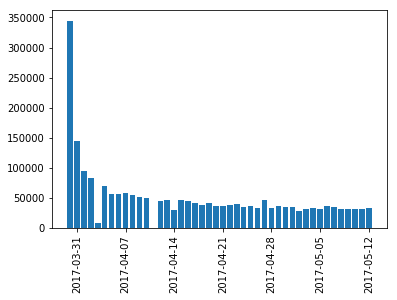

In [18]:
plt.bar(date_count['date'].tolist(), date_count['count'])
plt.xticks(rotation='vertical')

---
---
## Label definition

In [19]:
import datetime
from dateutil import parser

label_window_size = 14
label_window_end_date = parser.parse('2017-05-12').date()
label_window_start_date = label_window_end_date \
    - datetime.timedelta(label_window_size - 1)
print('label window:',label_window_start_date,
      '~',label_window_end_date,
      'days:',label_window_size)

feature_window_size = 30
feature_window_end_date = label_window_start_date - datetime.timedelta(1)
feature_window_start_date = feature_window_end_date \
    - datetime.timedelta(feature_window_size - 1)
print('feature window:',feature_window_start_date,
      '~',feature_window_end_date,'days:',feature_window_size)

# all the uid we will model
df_model_uid = df.filter((F.col('date')>=feature_window_start_date) \
                         & (F.col('date')<=feature_window_end_date))\
                    .select('uid').distinct()

# active in label window (active label=0)
df_active_uid_in_label_window = df.filter((F.col('date')>=label_window_start_date) \
                                          & (F.col('date')<=label_window_end_date))\
                            .select('uid').distinct().withColumn('label',F.lit(0))

label window: 2017-04-29 ~ 2017-05-12 days: 14
feature window: 2017-03-30 ~ 2017-04-28 days: 30


In [20]:
# df_active_uid_in_label_window.show()
# df_model_uid.show()

**1 means churn, 0 means still active**

In [21]:
# prepare label data (churn label=1; active label=0)
df_label = df_model_uid.join(df_active_uid_in_label_window,on=['uid'],how='left')
df_label = df_label.fillna(1)

In [22]:
df_label.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 6679|
|    0| 3078|
+-----+-----+



---
---
## Feature generation

In [23]:
# event_data in feature_window
df_feature_window = df.filter((F.col('date')>=feature_window_start_date) \
                              & (F.col('date')<=feature_window_end_date))

### Frequency features

In [24]:
# Recall our DataSet
df.show()

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168535490|    P| 6616004|2017-03-30|
|168551042|    P|  505355|2017-03-30|
|168540348|    P|   77260|2017-03-30|
|168530895|    P|       0|2017-03-30|
|168530479|    P| 1676759|2017-03-30|
|168551607|    P| 5517668|2017-03-30|
|168548101|    P| 6913185|2017-03-30|
|168542680|    P|       0|2017-03-30|
|168550237|    P| 6511070|2017-03-30|
|168519439|    P|       0|2017-03-30|
|168548942|    P| 4112522|2017-03-30|
|168551495|    P|22797719|2017-03-30|
|168551383|    P| 7149583|2017-03-30|
|168550382|    P| 3971726|2017-03-30|
|168548945|    P|20429929|2017-03-30|
|168550086|    P| 7172624|2017-03-30|
|168540348|    P| 6437996|2017-03-30|
|168551522|    P|  150918|2017-03-30|
|168541857|    P|  295529|2017-03-30|
|168546393|    P|  242615|2017-03-30|
+---------+-----+--------+----------+
only showing top 20 rows



##### method 1

In [25]:
# # define a function to generate frequency features
# def frequency_feature_generation(df,event,time_window,snapshot_date):
#     """
#     generate frequency features for one event type and one time window
#     """
#     df_feature = df.filter(F.col('event')==event)\
#             .filter((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
#                     & (F.col('date')<=snapshot_date))\
#             .groupBy('uid').agg(F.count(F.col('uid')).alias('freq_'+event+'_last_'+str(time_window)))
#     return df_feature

In [26]:
# # generate one feature
# event = 'S'
# time_window = 3
# snapshot_date = feature_window_end_date
# df_feature = frequency_feature_generation(df_feature_window,event,time_window,snapshot_date)

In [27]:
# df_feature.show(5)

In [28]:
# # generate frequency features for all event_list, time_window_list
# event_list = ['P','D','S']
# time_window_list = [1,3,7,14,30]
# df_feature_list = []
# for event in event_list:
#     for time_window in time_window_list:
#         df_feature_list.append(frequency_feature_generation(df_feature_window,event,time_window,snapshot_date))
# df_feature_list

##### method 2: too many dfs to join? do it another way

In [29]:
# print([1,2], *[1,2])

In [30]:
# define a function to generate frequency features for a list of time windows
# using when().otherwise(), and list comprehension trick!
def frequency_feature_generation_time_windows(df,event,time_window_list,snapshot_date):
    """
    generate frequency features for one event type and a list of time windows
    """
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date),1).otherwise(0))\
               .alias('freq_'+event+'_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [31]:
# generate one event type, all time windows 
event = 'S'
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date
df_feature = frequency_feature_generation_time_windows(df_feature_window,event,time_window_list,snapshot_date)
df_feature.show(5)

+---------+-------------+-------------+-------------+--------------+--------------+
|      uid|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+
|168552245|            0|            0|            0|             0|             8|
|168556386|            0|            0|            0|             0|             2|
|168625286|            0|            0|            0|             0|             2|
|168667784|            0|            0|            0|             0|             9|
|168673276|            0|            0|            0|             0|            12|
+---------+-------------+-------------+-------------+--------------+--------------+
only showing top 5 rows



In [32]:
# generate frequency features for all event_list, time_window_list
event_list = ['P','D','S']
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date

df_feature_list = []
for event in event_list:
    df_feature_list.append(frequency_feature_generation_time_windows(df_feature_window,event,
                                                                     time_window_list,snapshot_date))


In [33]:
df_feature_list

[DataFrame[uid: int, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint],
 DataFrame[uid: int, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint],
 DataFrame[uid: int, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint]]

### Recency features

In [34]:
# defined as days from last event
# can generate one feature for each type of event

from datetime import timedelta
def recency_feature_generation_time_windows(df,event,snapshot_date):
    """
    generate recency features for one event type, so totally 3 possible features
    """
#     df_feature = df \
#         .filter(F.col('event')==event) \
#         .groupBy('uid') \
#         .agg(F.max(F.col('date')).alias('rec_' + event + '_date') 
#             ) \
#         .withColumn('snapshot_date', F.lit(snapshot_date))
#     df_feature = df_feature.withColumn('rec_' + event, F.datediff(F.col('snapshot_date'), 
#                                                                   F.col('rec_' + event + '_date')))
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid') \
        .agg(F.datediff(F.lit(snapshot_date), F.max(F.col('date'))).alias('rec_' + event) 
            ) 
    
    return df_feature

In [35]:
# generate one event type, all time windows 
event = 'S'
snapshot_date = feature_window_end_date
df_feature = recency_feature_generation_time_windows(df_feature_window,event,
                                                       snapshot_date)
df_feature.show(10)

+---------+-----+
|      uid|rec_S|
+---------+-----+
|168552245|   29|
|168556386|   29|
|168625286|   29|
|168667784|   26|
|168673276|   29|
|168678563|    5|
|168757796|    1|
|168814832|   15|
|168816012|   29|
|168819137|   29|
+---------+-----+
only showing top 10 rows



In [36]:
# generate recency features for all event_list
event_list = ['P','D','S']
snapshot_date = feature_window_end_date

for event in event_list:
    df_feature_list.append(recency_feature_generation_time_windows(df_feature_window,event,
                                                                     snapshot_date))
df_feature_list

[DataFrame[uid: int, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint],
 DataFrame[uid: int, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint],
 DataFrame[uid: int, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint],
 DataFrame[uid: int, rec_P: int],
 DataFrame[uid: int, rec_D: int],
 DataFrame[uid: int, rec_S: int]]

### Acceleration Feature

To be added at the end of this file 

---
### Profile features

In [37]:
df_play = spark.read.csv('../data/play_ds.csv',header=True)
df_play.show(10)

+---------+------+-------+----------+---------+-----------+
|      uid|device|song_id|      date|play_time|song_length|
+---------+------+-------+----------+---------+-----------+
|168535490|    ar|6616004|2017-03-30|      283|        283|
|168551042|    ar| 505355|2017-03-30|      106|        277|
|168540348|    ar|  77260|2017-03-30|    64528|          0|
|168530895|    ar|      0|2017-03-30|      264|        265|
|168530479|    ar|1676759|2017-03-30|      338|        338|
|168551607|    ar|5517668|2017-03-30|      231|        245|
|168548101|    ip|6913185|2017-03-30|       40|        198|
|168542680|    ar|      0|2017-03-30|      284|        285|
|168550237|    ar|6511070|2017-03-30|      144|        237|
|168519439|    ar|      0|2017-03-30|      227|        228|
+---------+------+-------+----------+---------+-----------+
only showing top 10 rows



In [38]:
df_play_feature_window = df_play.filter((F.col('date')>=feature_window_start_date) \
                                        & (F.col('date')<=feature_window_end_date))
df_play_feature_window

DataFrame[uid: string, device: string, song_id: string, date: string, play_time: string, song_length: string]

In [39]:
df_profile_tmp = df_play_feature_window.select('uid','device').distinct()
df_profile_tmp.groupBy('device').count().show()

+------+-----+
|device|count|
+------+-----+
|    ar| 8640|
|    ip| 1125|
+------+-----+



9765 = 8640 + 1125. Thus no user has two devices

In [40]:
# check if one user has two devices
df_profile_tmp.count()

9765

Replace **iphone device with 1, and android device with 2**, for furthe modelling.

In [41]:
df_profile_tmp = df_profile_tmp.withColumn('device_type',F.when(F.col('device')=='ip',1).otherwise(2))
df_profile_tmp.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|          1| 1125|
|          2| 8640|
+-----------+-----+



<font color = red>
**Note that df_label is our "target" dataset. And we do all the joins based upon it**.

In [42]:
df_profile = df_label.select('uid').join(df_profile_tmp.select('uid','device_type'),on='uid',how='left')
df_profile.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|          1| 1125|
|          2| 8640|
+-----------+-----+



---
### Total play time features

Remember in the dataset, the type of play_time is "string", we have to convert it to "int"

In [43]:
# df_play_feature_window.show(10)
df_profile_tmp1 = df_play_feature_window.select('uid','date','play_time','song_length').distinct() \
    .withColumn('play_time', F.col('play_time').cast("float")) \
    .withColumn('song_length', F.col('song_length').cast('float'))

However, one need to pay special attention to the odd behaviors of "play_time" and "song_length".

In [44]:
df_profile_tmp1.describe().show()

+-------+--------------------+----------+-------------------+-------------------+
|summary|                 uid|      date|          play_time|        song_length|
+-------+--------------------+----------+-------------------+-------------------+
|  count|             1092280|   1092280|            1083275|            1092279|
|   mean|1.6655997408752608E8|      null|-381.16257441989154|-1641.3405991024893|
| stddev|1.5822782106036628E7|      null|  2063424.866350916|  2054774.116935796|
|    min|           104156596|2017-03-30|      -2.14748365E9|      -2.14748365E9|
|    max|            98212708|2017-04-28|          9888346.0|          2096042.0|
+-------+--------------------+----------+-------------------+-------------------+



<font color = red>
#### Clean play_time feature

1. Check all negative play_time and song_length 

Tiny proportion of play_time and song_length are negative, we can just remove them. 

In [45]:
N = df_profile_tmp1.count()
df_profile_tmp1.select(F.round(F.sum(F.when(F.col('play_time') < 0, 1).otherwise(0)) / N, 6)  \
                       .alias('play_time_neg_percentage'), 
                      F.round(F.sum(F.when(F.col('song_length') < 0, 1).otherwise(0)) / N, 6)  \
                       .alias('song_length_neg_percentage')).show()

+------------------------+--------------------------+
|play_time_neg_percentage|song_length_neg_percentage|
+------------------------+--------------------------+
|                  3.0E-6|                    6.0E-5|
+------------------------+--------------------------+



In [46]:
df_profile_tmp1 = df_profile_tmp1.filter((F.col('play_time') >= 0) & (F.col('song_length') >= 0))
df_profile_tmp1.describe().show()

+-------+--------------------+----------+------------------+------------------+
|summary|                 uid|      date|         play_time|       song_length|
+-------+--------------------+----------+------------------+------------------+
|  count|             1083207|   1083207|           1083207|           1083207|
|   mean|1.6655797537946394E8|      null|1593.7828071728877|265.94458994412713|
| stddev|1.5857028867894515E7|      null| 23217.96203477057| 309.7476090964457|
|    min|           104156596|2017-03-30|               0.0|               0.0|
|    max|            98212708|2017-04-28|         9888346.0|           10920.0|
+-------+--------------------+----------+------------------+------------------+



2. Remove the play_time that is longer than song_length. We treat it as some unknown systematic error.

In [47]:
df_profile_tmp1 = df_profile_tmp1.filter(F.col('play_time') <= F.col('song_length'))
df_profile_tmp1.describe().show()

+-------+--------------------+----------+------------------+-----------------+
|summary|                 uid|      date|         play_time|      song_length|
+-------+--------------------+----------+------------------+-----------------+
|  count|             1027416|   1027416|           1027416|          1027416|
|   mean|  1.66675004578166E8|      null|139.83209963660326|272.5067850879889|
| stddev|1.5342973993016796E7|      null|193.82412103161897|313.8591847895198|
|    min|           109031863|2017-03-30|               0.0|              0.0|
|    max|            98212708|2017-04-28|            8714.0|          10920.0|
+-------+--------------------+----------+------------------+-----------------+



In [48]:
# we do not exclude too much data points and the paly_time and song_length seems reasonable after this transfermation. 
df_profile_tmp1.count() / N

0.9406159592778408

Check the distribution of these two variables after cleansing.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e1f4160>,
      dtype=object)

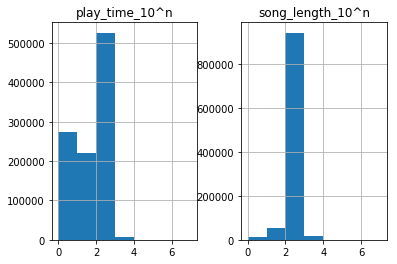

In [49]:
play_time_pd = df_profile_tmp1.toPandas()
import numpy as np
play_time_pd['play_time_10^n'] = np.log10(play_time_pd['play_time'] + 1)
play_time_pd['song_length_10^n'] = np.log10(play_time_pd['song_length'] + 1)

play_time_pd[['play_time_10^n', 'song_length_10^n']].hist(bins = np.arange(0, 8, 1))

<font color = red>
    Assign "target" user id to this feature by joining the final dataset to the left of DataFrame "df_label".

In [50]:
df_profile1 = df_label.select('uid').join(df_profile_tmp1.select('uid','date','play_time'),on='uid',how='left')
df_profile1.describe().show()

+-------+--------------------+----------+------------------+
|summary|                 uid|      date|         play_time|
+-------+--------------------+----------+------------------+
|  count|             1027610|   1027416|           1027416|
|   mean| 1.666752098840533E8|      null|139.83209963660326|
| stddev|1.5342076408365091E7|      null|193.82412103161897|
|    min|             2626270|2017-03-30|               0.0|
|    max|           168941043|2017-04-28|            8714.0|
+-------+--------------------+----------+------------------+



In [51]:
# Count Missing Values
df_profile1.select(*[F.sum(F.col(c).isNull().cast("int")).alias(c) \
                        for c in df_profile1.columns]).show()

+---+----+---------+
|uid|date|play_time|
+---+----+---------+
|  0| 194|      194|
+---+----+---------+



In [52]:
def play_time_feature_generation_time_windows(df,time_window_list,snapshot_date):
    """
    generate total song play time features (using play_ds data) for different time window
    """
    df_feature = df \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date),F.col('play_time')).otherwise(0))\
               .alias('play_time_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [53]:
# Recall df_profile1 
df_profile1.show(10)

+--------+----------+---------+
|     uid|      date|play_time|
+--------+----------+---------+
|34509854|2017-03-30|     51.0|
|34509854|2017-03-30|     62.0|
|34509854|2017-03-30|      0.0|
|34509854|2017-03-30|   1808.0|
|34509854|2017-04-28|    810.0|
|34509854|2017-03-30|    256.0|
|34509854|2017-03-30|    280.0|
|34509854|2017-04-04|    194.0|
|34509854|2017-03-30|    140.0|
|34509854|2017-04-04|    208.0|
+--------+----------+---------+
only showing top 10 rows



In [54]:
# all time windows 
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date

df_play_time_time_window = play_time_feature_generation_time_windows(df_profile1,
                                                                     time_window_list,snapshot_date)

In [55]:
df_play_time_time_window.show(10)

+---------+----------------+----------------+----------------+-----------------+-----------------+
|      uid|play_time_last_1|play_time_last_3|play_time_last_7|play_time_last_14|play_time_last_30|
+---------+----------------+----------------+----------------+-----------------+-----------------+
| 34509854|          4150.0|          4622.0|          4622.0|           4622.0|          55245.0|
| 56890349|          7173.0|         20678.0|         35220.0|          81315.0|         184721.0|
|168552245|             0.0|             0.0|             0.0|              0.0|         132670.0|
|168553859|             0.0|             0.0|             0.0|              0.0|           3819.0|
|168556386|             0.0|             0.0|             0.0|              0.0|            202.0|
|168556642|             0.0|             0.0|             0.0|              0.0|            250.0|
|168577890|             0.0|             0.0|             0.0|              0.0|            848.0|
|168590270

---
### Fancier frequency features

We still build this feature based upon the previous cleansing.

In [56]:
df_profile2 = df_label.select('uid').join(df_profile_tmp1.select('uid','date','play_time','song_length'),on='uid',how='left')
df_profile2.describe().show()

+-------+--------------------+----------+------------------+-----------------+
|summary|                 uid|      date|         play_time|      song_length|
+-------+--------------------+----------+------------------+-----------------+
|  count|             1027610|   1027416|           1027416|          1027416|
|   mean| 1.666752098840533E8|      null|139.83209963660326|272.5067850879889|
| stddev|1.5342076408365091E7|      null|193.82412103161897|313.8591847895197|
|    min|             2626270|2017-03-30|               0.0|              0.0|
|    max|           168941043|2017-04-28|            8714.0|          10920.0|
+-------+--------------------+----------+------------------+-----------------+



In [57]:
# Count Missing Values
df_profile2.select(*[F.sum(F.col(c).isNull().cast("int")).alias(c) \
                        for c in df_profile2.columns]).show()

+---+----+---------+-----------+
|uid|date|play_time|song_length|
+---+----+---------+-----------+
|  0| 194|      194|        194|
+---+----+---------+-----------+



In [68]:
df_profile2_copy = df_profile2.cache()

In [70]:
df_pro2_pd = df_profile2_copy.withColumn('ratio', F.col('play_time')/F.col('song_length')).toPandas()

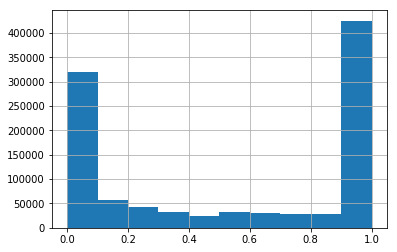

In [71]:
df_pro2_pd['ratio'].hist()

In [58]:
def relative_freq_feature_generation_time_windows(df,time_window_list,snapshot_date):
    """
    generate counts of songs play 80% of their song length (using play_ds data) for different time window
    """
    df_feature = df \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date) \
                            & (F.col('play_time')/F.col('song_length')>=0.8),1).otherwise(0))\
               .alias('rela_freq_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [59]:
# all time windows 
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date

df_relative_freq_time_window = relative_freq_feature_generation_time_windows(df_profile2,
                                                                     time_window_list,snapshot_date)

In [60]:
df_relative_freq_time_window.show(10)

+---------+----------------+----------------+----------------+-----------------+-----------------+
|      uid|rela_freq_last_1|rela_freq_last_3|rela_freq_last_7|rela_freq_last_14|rela_freq_last_30|
+---------+----------------+----------------+----------------+-----------------+-----------------+
| 34509854|               4|               5|               5|                5|               67|
| 56890349|              28|              82|             141|              328|              751|
|168552245|               0|               0|               0|                0|               80|
|168553859|               0|               0|               0|                0|                0|
|168556386|               0|               0|               0|                0|                0|
|168556642|               0|               0|               0|                0|                1|
|168577890|               0|               0|               0|                0|                3|
|168590270

---
### Append all new features to df_profile

In [61]:
[df_profile, df_play_time_time_window, df_relative_freq_time_window]

[DataFrame[uid: int, device_type: int],
 DataFrame[uid: int, play_time_last_1: double, play_time_last_3: double, play_time_last_7: double, play_time_last_14: double, play_time_last_30: double],
 DataFrame[uid: int, rela_freq_last_1: bigint, rela_freq_last_3: bigint, rela_freq_last_7: bigint, rela_freq_last_14: bigint, rela_freq_last_30: bigint]]

In [62]:
df_new_feature_list = [df_profile, df_play_time_time_window, df_relative_freq_time_window]

---
---
## Form training data
We are going to join every new DataFrame we generated to the df_label dataset

In [63]:
def join_feature_data(df_master,df_feature_list):
    for df_feature in df_feature_list:
        df_master = df_master.join(df_feature,on='uid',how='left')
        #df_master.persist() # uncomment if number of joins is too many
    return df_master    

In [64]:
# join all behavior features
df_model_final = join_feature_data(df_label,df_feature_list)

In [65]:
# join all profile features
df_model_final = join_feature_data(df_model_final, df_new_feature_list)

### Add acceleration features

In [66]:
df_model_final = df_model_final.withColumn('play_1_over_play_7', F.col('freq_P_last_1')/F.col('freq_P_last_7')) \
                                .withColumn('play_1_over_down_1', F.col('freq_P_last_1')/F.col('freq_D_last_1')) \
                                .withColumn('play_1_over_down_7', F.col('freq_P_last_1')/F.col('freq_D_last_7'))

In [67]:
df_model_final.fillna(0).toPandas().to_csv('../data/df_model_final.csv',index=False)